# Classificador facial de olhos abertos ou fechados
## Projeto VIII - Visão Computacional e Aprendizado de Máquina 
Autor: Luís Gabriel Pereira Condados

In [1]:
import cv2
import dlib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Download do shape_predictor: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [2]:
DATA_BASE_DIR   = "../dataset/"
CLOSED_FACE_DIR = "../dataset/ClosedFace/"
OPEN_FACE_DIR   = "../dataset/OpenFace/"
PREDICTOR_PATH  = "../shape_predictor_68_face_landmarks.dat"

In [3]:
# 6 pontos por olho (x,y) ==> 12(x,y) * 2(dois olhos) ==> 24
# eye aspectio ratio (EAR) == 2 (1 por olho)
N_FEATURES = 22

In [4]:
# Jaw line = 0 to 16
# Left Eyebrow = 17 to 21
# Right Eyebrow = 22 to 26
# Nose = 27 to 35
# Left Eye = 36 to 41
# Right Eye = 42 to 47
# Lips = 48 to 60
# Mouth Opening = 61 to 67
facial_landmarks_idxs = {
    "jaw_line":range(0,17),
    "left_eyebrow":range(17,22),
    "right_eyebrow":range(22,27),
    "nose":range(27,36),
    "left_eye":range(36,42),
    "right_eye":range(42,48),
    "lips":range(48,61),
    "mouth_opening":range(61,68)
}
facial_landmarks_idxs.keys()

dict_keys(['jaw_line', 'left_eyebrow', 'right_eyebrow', 'nose', 'left_eye', 'right_eye', 'lips', 'mouth_opening'])

## Funções Auxiliares

In [5]:
# detector de faces
detector  = dlib.get_frontal_face_detector()
# identificador dos landmarks
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [6]:
def crop_eyes_region(image, landmarks):
    eyes_points_idxs = list(facial_landmarks_idxs['left_eye']) + list(facial_landmarks_idxs['right_eye'])
    eyes_points = landmarks[eyes_points_idxs]
    
    bbox = segment_eyes_region(image, landmarks)
    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]
    
    eyes_image = image[y1:y2, x1:x2]
    
    return eyes_image, bbox

In [7]:
def segment_eyes_region(image, landmarks):
    eyes_points_idxs = list(facial_landmarks_idxs['left_eye']) + list(facial_landmarks_idxs['right_eye'])
    eyes_points = landmarks[eyes_points_idxs]
    
    bbox = cv2.boundingRect(eyes_points)
    return bbox

In [47]:
def my_simple_predictor(X, thr=0.1):    
    y_pred = [(np.average(xi[:2]) > thr) for xi in X]
    return np.array(y_pred,dtype='int')

In [9]:
def eye_ratio(eye_points):
    eye_points = np.array(eye_points, dtype=float)
    
    A = np.linalg.norm(eye_points[1] - eye_points[5])
    B = np.linalg.norm(eye_points[2] - eye_points[4])
    C = np.linalg.norm(eye_points[3] - eye_points[0])
    
    r = (A+B)/(2.0*C)
    
    return r

In [10]:
# imagem: imagem contendo o rosto
# retorna um numpy array contendo as marcações faciais (x,y)
def get_landmarks(image, face_loc=None):  
    # obs.: supondo que existe apenas um rosto por imagem e ocupa toda a imagem
    if face_loc == None:
        face_loc = dlib.rectangle(0, 0, image.shape[0], image.shape[1])
    landmarks = predictor(image, face_loc)
    
    #convertendo os pontos para numpy array
    pts = [(landmarks.part(n).x,landmarks.part(n).y) for n in range(68)]
    pts = np.array(pts, dtype='int')
    
    return pts

In [11]:
def extract_features(image, face_loc=None):
    features  = np.empty(())
    landmarks = get_landmarks(image, face_loc)
    
    #pega apenas os 6 pontos que representam a regiao de interesse
    #pontos do olho esquerdo
    left_eye_pts  = landmarks[facial_landmarks_idxs['left_eye'],:]
    #pontos do olho direito
    right_eye_pts = landmarks[facial_landmarks_idxs['right_eye'],:]
    
    #proporção do olho esquerdo
    lratio = eye_ratio(left_eye_pts)
    #proporção do olho direito
    rratio = eye_ratio(right_eye_pts)
    
    #histograma
    eyes_region, _ = crop_eyes_region(image, landmarks)
    eyes_region = cv2.resize(eyes_region, (100,10))
    
    hist = cv2.calcHist(eyes_region,channels=[0], mask=None, histSize=[20], ranges=[0,255])
    cv2.normalize(hist,hist)
    
#     eyes_points_idxs = list(facial_landmarks_idxs['left_eye']) + list(facial_landmarks_idxs['right_eye'])
#     eyes_points = landmarks[eyes_points_idxs]
#     return eyes_points.flatten()

    return [lratio] + [rratio] + hist.flatten().tolist()

In [12]:
def draw_landmarks(image, landmarks):
    img_out = image.copy()
    
    for landmark in landmarks:
        img_out = cv2.circle(img_out, tuple(landmark), 1 , 255, cv2.FILLED)    
    
    return img_out

In [13]:
def confusion_matrix(y_true, y_pred, n_classes=2):
    
    assert(len(y_true) == len(y_pred))
    
    cm = np.zeros([n_classes, n_classes], dtype='int')
    
    y_true = y_true.astype('int')
    y_pred = y_pred.astype('int')
    
    
    for i in range(len(y_true)):
        real = y_true[i]
        pred = y_pred[i]
        cm[real,pred] += 1
    
    return cm

In [14]:
def compute_metrics_from_cm(cm):
    metrics = {}
    
    TP, FN, FP, TN = cm.flatten()
    
    metrics["accuracy"] =  (TP + TN)/cm.sum()
    metrics["precision"]=  TP / (TP + FP)
    metrics["recall"]   =  TP / (TP + FN)
    metrics["f1_score"] =  2.0*TP/(2.0*TP + FP + FN)
    
    return metrics

## Carregando o dataset

In [15]:
import glob

In [16]:
faces_closed = []
faces_opened = []
for f in glob.glob(os.path.join(CLOSED_FACE_DIR, "*.jpg")):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (3,3), 0)    
    faces_closed.append(img)
for f in glob.glob(os.path.join(OPEN_FACE_DIR, "*.jpg")):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (3,3), 0)
    faces_opened.append(img)

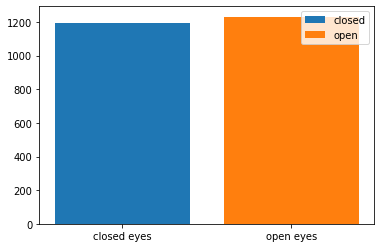

In [17]:
fig, ax = plt.subplots()

ax.bar(0, len(faces_closed), label='closed')
ax.bar(1, len(faces_opened), label='open')
ax.legend()
ax.set_xticks(np.arange(0,2))
ax.set_xticklabels(['closed eyes', 'open eyes'])
plt.show()

## Criando o vetor de caracteristicas e o vetor de label

**Obs.:** Codificação das labels:

| Estado dos olhos | y |
|:--------------:|:-------------:|
|       Fechado        |       0       |
|       Aberto        |       1       |

In [18]:
X = []
y = []
for img in faces_closed:
    features = extract_features(img)
    X.append(features)
    y.append(0)

for img in faces_opened:
    features = extract_features(img)
    X.append(features)
    y.append(1)

In [19]:
# convertendo para numpy array
X = np.array(X).reshape(-1,N_FEATURES)
y = np.array(y).reshape(-1)

In [20]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2423, 10)
y shape: (2423,)


## Separando os dados para validação cruzada

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [23]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1938, 10)
y_train shape: (1938,)
X_test shape: (485, 10)
y_test shape: (485,)


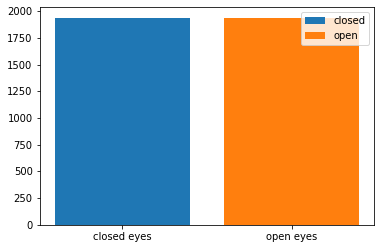

In [24]:
fig, ax = plt.subplots()

ax.bar(0, len(y_train==0), label='closed')
ax.bar(1, len(y_train==1), label='open')
ax.legend()
ax.set_xticks(np.arange(0,2))
ax.set_xticklabels(['closed eyes', 'open eyes'])
plt.show()

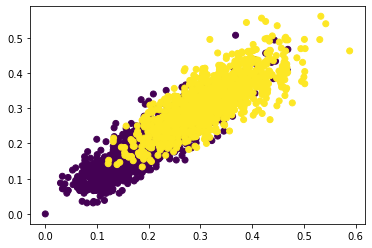

In [25]:
plt.scatter(X[:,0], X[:,1], c=y[:])
plt.show()

## Criando o modelo, o classificador

In [26]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [49]:
# SVM
# svm_model = svm.SVC(C=1.0,kernel='linear')
svm_model = svm.SVC(C=2.0)
# Decision Tree
tree_model= tree.DecisionTreeClassifier()
# Random Forest
rforest_model = RandomForestClassifier(n_estimators=10, max_depth=None)

## Treinamento

In [51]:
svm_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
rforest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

## Validação

{'accuracy': 0.8206185567010309, 'precision': 0.8416988416988417, 'recall': 0.8257575757575758, 'f1_score': 0.8336520076481836}


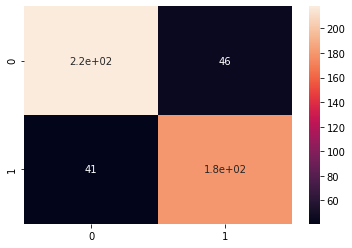

In [48]:
y_pred = my_simple_predictor(X_test,thr=0.25)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(compute_metrics_from_cm(cm))

{'accuracy': 0.8618556701030928, 'precision': 0.9053497942386831, 'recall': 0.8333333333333334, 'f1_score': 0.8678500986193294}


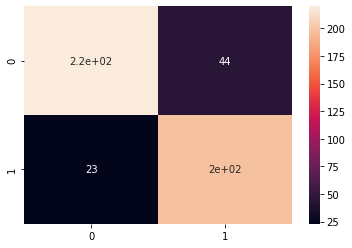

In [52]:
y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(compute_metrics_from_cm(cm))

{'accuracy': 0.8103092783505155, 'precision': 0.8412698412698413, 'recall': 0.803030303030303, 'f1_score': 0.8217054263565892}


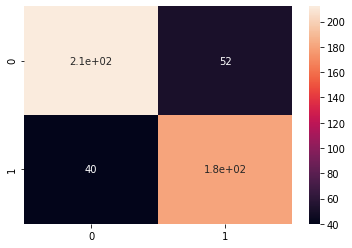

In [45]:
y_pred = tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(compute_metrics_from_cm(cm))

{'accuracy': 0.8494845360824742, 'precision': 0.8804780876494024, 'recall': 0.8371212121212122, 'f1_score': 0.858252427184466}


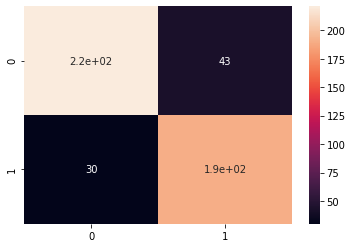

In [46]:
y_pred = rforest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
print(compute_metrics_from_cm(cm))

# TESTES

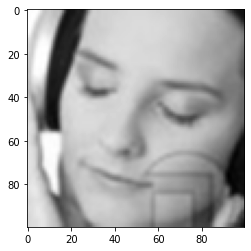

In [33]:
%matplotlib inline

img = faces_closed[np.random.randint(len(faces_closed))]

plt.imshow(img, 'gray')

plt.show()

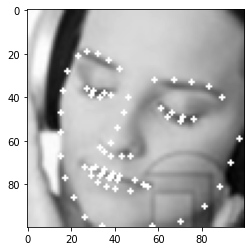

In [34]:
landmarks = get_landmarks(img)
img_t = draw_landmarks(img, landmarks)

plt.imshow(img_t, 'gray')
plt.show()

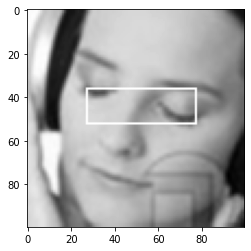

In [35]:
bbox = segment_eyes_region(img, landmarks)
seg_img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1] + bbox[3]), 255, 1)

plt.imshow(seg_img, cmap='gray')
plt.show()

In [36]:
extract_features(img)

[0.2476302782718243,
 0.22360679774997896,
 0.0,
 0.0,
 0.0,
 0.31139957904815674,
 0.4670993685722351,
 0.6227991580963135,
 0.5449492931365967,
 0.0]

In [37]:
img.shape

(100, 100)

In [38]:
df = pd.DataFrame()
df["Images"] = faces_closed + faces_opened
df["X1"]= X[:,0]
df["X2"]= X[:,1]
df["y"] = y

In [39]:
thr = 0.2
df[((df.X1 <= thr)|(df.X2 <= thr))&(df.y == 1)].head(2)

,Images,X1,X2,y
1196,"[[36, 34, 33, 34, 39, 52, 64, 67, 65, 64, 62, ...",0.248069,0.176471,1
1200,"[[32, 33, 36, 42, 52, 61, 60, 46, 28, 19, 17, ...",0.205214,0.148741,1


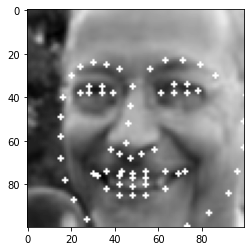

[0.2571922625628131, 0.24961508830135312, 0.0, 0.0, 0.7484170198440552, 0.5559669137001038, 0.3207501471042633, 0.12830005586147308, 0.08553337305784225, 0.06415002793073654]


In [40]:
img = df[df.y == 1]["Images"][1334]
landmarks = get_landmarks(img)
img = draw_landmarks(img, landmarks)
plt.imshow(img,cmap='gray')
plt.show()

print(extract_features(img))

# Referências
[dlib] http://dlib.net/face_landmark_detection.py.html